In [0]:
# Desmontar o ponto de montagem existente
dbutils.fs.unmount("/mnt/paris2024")

# Configurações da conta de armazenamento
account_name = "***********"
container_name = "paris2024"  # Nome do contêiner
account_key = "**************************************************" #chave de acesso

# Configuração da URL do Data Lake
wasbs_url = f"wasbs://{container_name}@{account_name}.blob.core.windows.net/"

# Configurações para a autenticação 
configs = {
  f"fs.azure.account.key.{account_name}.blob.core.windows.net": account_key
}

# Montar o contêiner "paris2024" no Databricks
dbutils.fs.mount(
  source = wasbs_url,
  mount_point = "/mnt/paris2024",
  extra_configs = configs
)

# Listar diretório "bronze" no contêiner "paris2024"
display(dbutils.fs.ls("/mnt/paris2024/bronze"))

/mnt/paris2024 has been unmounted.


path,name,size,modificationTime
dbfs:/mnt/paris2024/bronze/skatefeminino.csv,skatefeminino.csv,530,1722258944000
dbfs:/mnt/paris2024/bronze/skatemasculino.csv,skatemasculino.csv,518,1722282352000


In [0]:
from pyspark.sql.functions import lit, col

# Caminhos para os arquivos CSV
csv_file_path_feminino = "/mnt/paris2024/bronze/skatefeminino.csv"
csv_file_path_masculino = "/mnt/paris2024/bronze/skatemasculino.csv"

# Ler os arquivos CSV
df_feminino = spark.read.option("delimiter", ";").csv(csv_file_path_feminino, header=True, inferSchema=True)
df_masculino = spark.read.option("delimiter", ";").csv(csv_file_path_masculino, header=True, inferSchema=True)

# Remover colunas indesejadas
columns_to_remove = ["_c10", "_c11", "_c12"]
df_feminino = df_feminino.drop(*columns_to_remove)
df_masculino = df_masculino.drop(*columns_to_remove)

# Adicionar coluna de identificação do gênero
df_feminino = df_feminino.withColumn("Genero", lit("Feminino"))
df_masculino = df_masculino.withColumn("Genero", lit("Masculino"))

# Mostrar as colunas de cada DataFrame após remoção
print("Colunas do DataFrame Feminino:", df_feminino.columns)
print("Colunas do DataFrame Masculino:", df_masculino.columns)

# Adicionar colunas faltantes com valores nulos para garantir que ambos tenham o mesmo esquema
for column in df_feminino.columns:
    if column not in df_masculino.columns:
        df_masculino = df_masculino.withColumn(column, lit(None))

for column in df_masculino.columns:
    if column not in df_feminino.columns:
        df_feminino = df_feminino.withColumn(column, lit(None))

# Reordenar as colunas para garantir que a ordem seja a mesma
common_columns = sorted(set(df_feminino.columns).intersection(df_masculino.columns))
df_feminino = df_feminino.select(common_columns)
df_masculino = df_masculino.select(common_columns)

# Combinar os DataFrames
df_combined = df_feminino.union(df_masculino)


# Remover colunas 'Total' e 'Medalha'
df_combined = df_combined.drop("Total", "Medalha")

# Exibir o DataFrame combinado
print("DataFrame Combinado")
df_combined.show(truncate=False)


Colunas do DataFrame Feminino: ['Rank', 'Nome', 'code', 'Run 1', 'Run 2', 'Trick 1', 'Trick  2', 'Trick  3', 'Trick 4', 'Trick 5', 'Genero']
Colunas do DataFrame Masculino: ['Rank', 'Nome', 'code', 'Run 1', 'Run 2', 'Trick 1', 'Trick  2', 'Trick  3', 'Trick 4', 'Trick 5', 'Genero']
DataFrame Combinado
+---------+--------------+----+-----+-----+--------+--------+-------+-------+-------+----+
|Genero   |Nome          |Rank|Run 1|Run 2|Trick  2|Trick  3|Trick 1|Trick 4|Trick 5|code|
+---------+--------------+----+-----+-----+--------+--------+-------+-------+-------+----+
|Feminino |YOSHIZAWA Coco|1   |85.02|86.8 |86.34   |0.0     |0.0    |96.49  |89.46  |JPN |
|Feminino |AKAMA Liz     |2   |89.26|92.62|0.0     |0.0     |84.07  |0.0    |0.0    |JPN |
|Feminino |LEAL Rayssa   |3   |71.66|34.8 |92.88   |0.0     |0.0    |0.0    |88.83  |BRA |
|Feminino |CUI Chenxi    |4   |65.47|65.04|89.11   |0.0     |86.98  |0.0    |0.0    |CHN |
|Feminino |PINSON Poe    |5   |36.75|50.18|0.0     |88.43   

In [0]:
# Colunas do df pandas
print(df_feminino.columns)
print(df_masculino.columns)


['Genero', 'Nome', 'Rank', 'Run 1', 'Run 2', 'Trick  2', 'Trick  3', 'Trick 1', 'Trick 4', 'Trick 5', 'code']
['Genero', 'Nome', 'Rank', 'Run 1', 'Run 2', 'Trick  2', 'Trick  3', 'Trick 1', 'Trick 4', 'Trick 5', 'code']


In [0]:
# Tabela de armazenamento dos dados
%sql
CREATE DATABASE IF NOT EXISTS bronze;


In [0]:
from pyspark.sql.functions import col

# Dados de exemplo para renomeação
# Colunas estão sendo renomeadas para remover espaços e garantir a conformidade

# Renomeação para df_feminino
df_feminino_renamed = df_feminino \
    .withColumnRenamed("Genero", "Genero") \
    .withColumnRenamed("Nome", "Nome") \
    .withColumnRenamed("Rank", "Rank") \
    .withColumnRenamed("Run 1", "Run_1") \
    .withColumnRenamed("Run 2", "Run_2") \
    .withColumnRenamed("Trick  2", "Trick_2") \
    .withColumnRenamed("Trick  3", "Trick_3") \
    .withColumnRenamed("Trick 1", "Trick_1") \
    .withColumnRenamed("Trick 4", "Trick_4") \
    .withColumnRenamed("Trick 5", "Trick_5") \
    .withColumnRenamed("code", "code")

# Renomeação para df_masculino
df_masculino_renamed = df_masculino \
    .withColumnRenamed("Genero", "Genero") \
    .withColumnRenamed("Nome", "Nome") \
    .withColumnRenamed("Rank", "Rank") \
    .withColumnRenamed("Run 1", "Run_1") \
    .withColumnRenamed("Run 2", "Run_2") \
    .withColumnRenamed("Trick  2", "Trick_2") \
    .withColumnRenamed("Trick  3", "Trick_3") \
    .withColumnRenamed("Trick 1", "Trick_1") \
    .withColumnRenamed("Trick 4", "Trick_4") \
    .withColumnRenamed("Trick 5", "Trick_5") \
    .withColumnRenamed("code", "code")

# Salvar DataFrame feminino renomeado em uma tabela
df_feminino_renamed.write.format('delta').mode('overwrite').saveAsTable('bronze.olimpiadasdeskate_feminino')

# Salvar DataFrame masculino renomeado em uma tabela
df_masculino_renamed.write.format('delta').mode('overwrite').saveAsTable('bronze.olimpiadasdeskate_masculino')




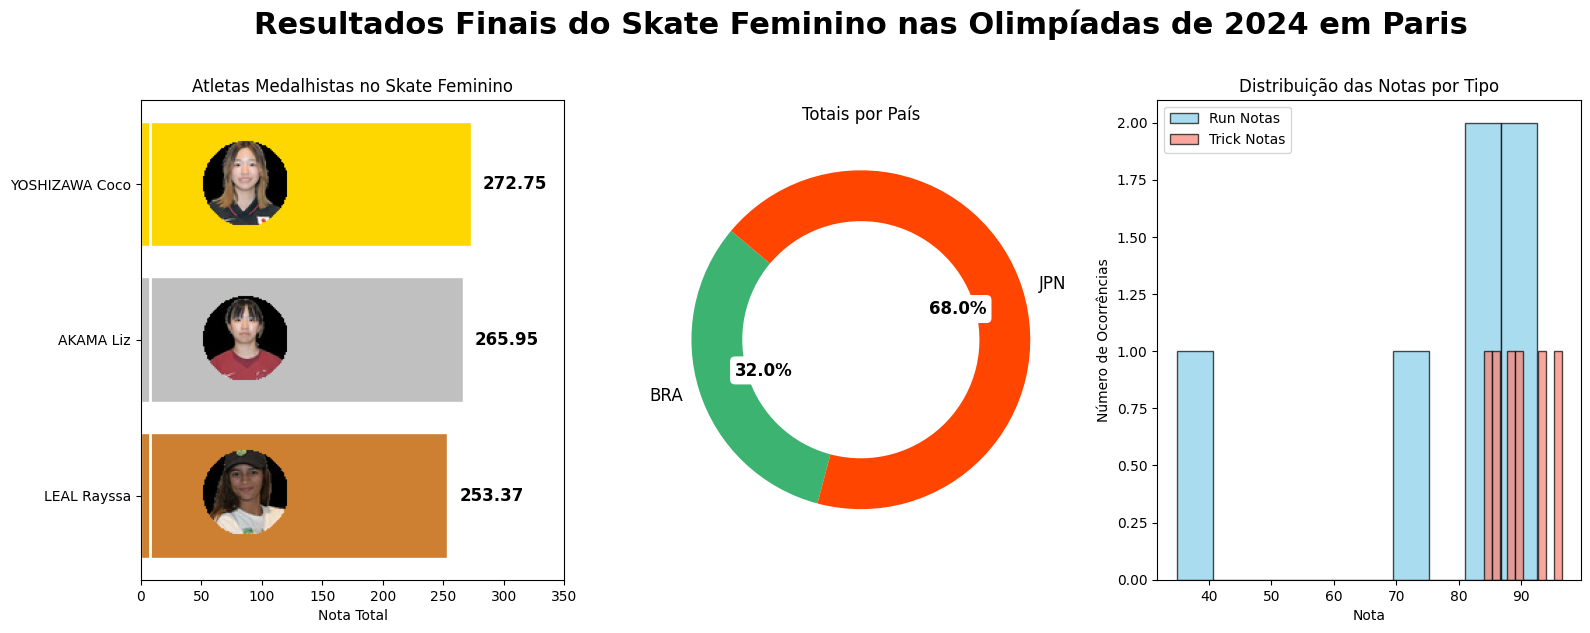

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import requests
from PIL import Image, ImageDraw
from io import BytesIO
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.patches import Rectangle
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf
from pyspark.sql.types import FloatType

# Configurações e Constantes
MEDAL_COLORS = {1: '#FFD700', 2: '#C0C0C0', 3: '#cd7f32'}
DEFAULT_COLOR = '#4C72B0'
COUNTRY_COLORS = {
    'JPN': '#FF4500',
    'USA': '#1E90FF',
    'BRA': '#3CB371',
    'CHN': '#FFD700'
}
IMAGE_URLS = {
    'YOSHIZAWA Coco': 'https://ssl.gstatic.com/onebox/media/sports/headshots/9qngI6uyWwliJpxD_108x108.jpg',
    'AKAMA Liz': 'https://ssl.gstatic.com/onebox/media/sports/headshots/RAJBqwIVa-2J_E3g_108x108.jpg',
    'LEAL Rayssa': 'https://ssl.gstatic.com/onebox/media/sports/headshots/e24UUnZHGOd8YI6P_108x108.jpg'
}

# Inicializa a SparkSession
spark = SparkSession.builder.appName("SkateOlimpico").getOrCreate()

# Função UDF para calcular a soma das 3 maiores notas
def top_3_sum(*args):
    notas = sorted((nota for nota in args if nota > 0), reverse=True)
    return float(sum(notas[:3]))

top_3_sum_udf = udf(top_3_sum, FloatType())

# Atualizando os nomes das colunas conforme o seu DataFrame
df_feminino = df_feminino.withColumn('Total', top_3_sum_udf(
    col('Run 1'), col('Run 2'), col('Trick 1'), col('Trick  2'), col('Trick  3'), col('Trick 4'), col('Trick 5')
)).withColumn('Medalha', col('Rank').cast('int'))

# Converter para Pandas e filtrar medalhistas
df_pandas = df_feminino.toPandas()
df_pandas = df_pandas[df_pandas['Medalha'].isin([1, 2, 3])]

# Função para carregar imagem
def load_image_from_url(url):
    try:
        response = requests.get(url)
        return Image.open(BytesIO(response.content)).convert("RGBA")
    except Exception as e:
        print(f"Erro ao carregar imagem: {e}")
        return None

# Função para criar uma imagem circular com borda
def make_circle_image(image, radius=30, border_color='#FFFFFF', border_width=5):
    image = image.resize((2 * radius, 2 * radius), Image.LANCZOS)
    mask = Image.new("L", (2 * radius, 2 * radius), 0)
    draw = ImageDraw.Draw(mask)
    draw.ellipse((0, 0, 2 * radius, 2 * radius), fill=255)
    circle_image = Image.new("RGBA", (2 * radius, 2 * radius))
    circle_image.paste(image, (0, 0), mask=mask)
    border = Image.new("RGBA", (2 * radius + 2 * border_width, 2 * radius + 2 * border_width), border_color)
    border.paste(circle_image, (border_width, border_width), mask=mask)
    return border

# Configurar a figura e os subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Gráfico 1: Medalhistas
top_atletas = df_pandas[['Nome', 'Total', 'Medalha']].sort_values(by='Total', ascending=False)
bars = axs[0].barh(top_atletas['Nome'], top_atletas['Total'], color=[MEDAL_COLORS.get(medal, DEFAULT_COLOR) for medal in top_atletas['Medalha']], edgecolor='white')

# Adicionar uma borda externa branca ao redor do gráfico
axs[0].add_patch(Rectangle(
    (axs[0].get_position().x0 - 0.02, axs[0].get_position().y0 - 0.02),  # Posição do retângulo (margem extra)
    axs[0].get_position().width + 0.04,  # Largura do retângulo (largura do gráfico + margem extra)
    axs[0].get_position().height + 0.04,  # Altura do retângulo (altura do gráfico + margem extra)
    transform=fig.transFigure,  # Coordenadas relativas à figura
    color='white',  # Cor da borda
    fill=False,  # Não preencher o retângulo
    linewidth=2  # Largura da borda
))

# Adicionar imagens circulares sobre as barras
for i, nome in enumerate(top_atletas['Nome']):
    if nome in IMAGE_URLS:
        img = load_image_from_url(IMAGE_URLS[nome])
        if img:
            img_circular = make_circle_image(img, radius=30, border_color=MEDAL_COLORS.get(top_atletas.iloc[i]['Medalha'], DEFAULT_COLOR))
            bar_width = bars[i].get_width()
            img_width, img_height = img_circular.size
            x = bars[i].get_x() + 5
            y = bars[i].get_y() + (bars[i].get_height() - img_height) / 2
            imagebox = OffsetImage(img_circular, zoom=1.0, resample=True)
            ab = AnnotationBbox(imagebox, (x + img_width / 2, y + img_height / 2), frameon=False, pad=0, xycoords='data', boxcoords="offset points")
            axs[0].add_artist(ab)
    axs[0].text(bars[i].get_width() + 10, bars[i].get_y() + bars[i].get_height() / 2, f'{top_atletas.iloc[i]["Total"]:.2f}', ha='left', va='center', color='black', fontsize=12, fontweight='bold')

# Ajustar o gráfico de medalhistas
axs[0].set_xlim(0, 350)
axs[0].set_title('Atletas Medalhistas no Skate Feminino')
axs[0].set_xlabel('Nota Total')
axs[0].invert_yaxis()

# Gráfico 2: Distribuição das Notas Totais por País
country_total = df_pandas.groupby('code')['Total'].sum()
colors_pie = [COUNTRY_COLORS.get(country, DEFAULT_COLOR) for country in country_total.index]
wedges, texts, autotexts = axs[1].pie(
    country_total,
    labels=country_total.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors_pie,
    wedgeprops=dict(width=0.3),
    textprops=dict(color='black', fontsize=12)
)
axs[1].set_title('Totais por País')

# Destacar os valores no gráfico de rosca
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(12)
    autotext.set_fontweight('bold')
    autotext.set_bbox(dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3'))

# Gráfico 3: Distribuição das Notas por Tipo (Run e Trick)
run_notas = df_pandas[['Run 1', 'Run 2']].values.flatten()
trick_notas = df_pandas[['Trick 1', 'Trick  2', 'Trick  3', 'Trick 4', 'Trick 5']].values.flatten()
run_notas = run_notas[run_notas > 0]
trick_notas = trick_notas[trick_notas > 0]

axs[2].hist(run_notas, bins=10, alpha=0.7, label='Run Notas', color='skyblue', edgecolor='black')
axs[2].hist(trick_notas, bins=10, alpha=0.7, label='Trick Notas', color='salmon', edgecolor='black')
axs[2].set_title('Distribuição das Notas por Tipo')
axs[2].set_xlabel('Nota')
axs[2].set_ylabel('Número de Ocorrências')
axs[2].legend()

# Ajuste para evitar o erro do tight_layout
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
plt.suptitle("Resultados Finais do Skate Feminino nas Olimpíadas de 2024 em Paris", fontsize=22, fontweight='bold', y=1.05)

# Mostrar o gráfico
plt.show()


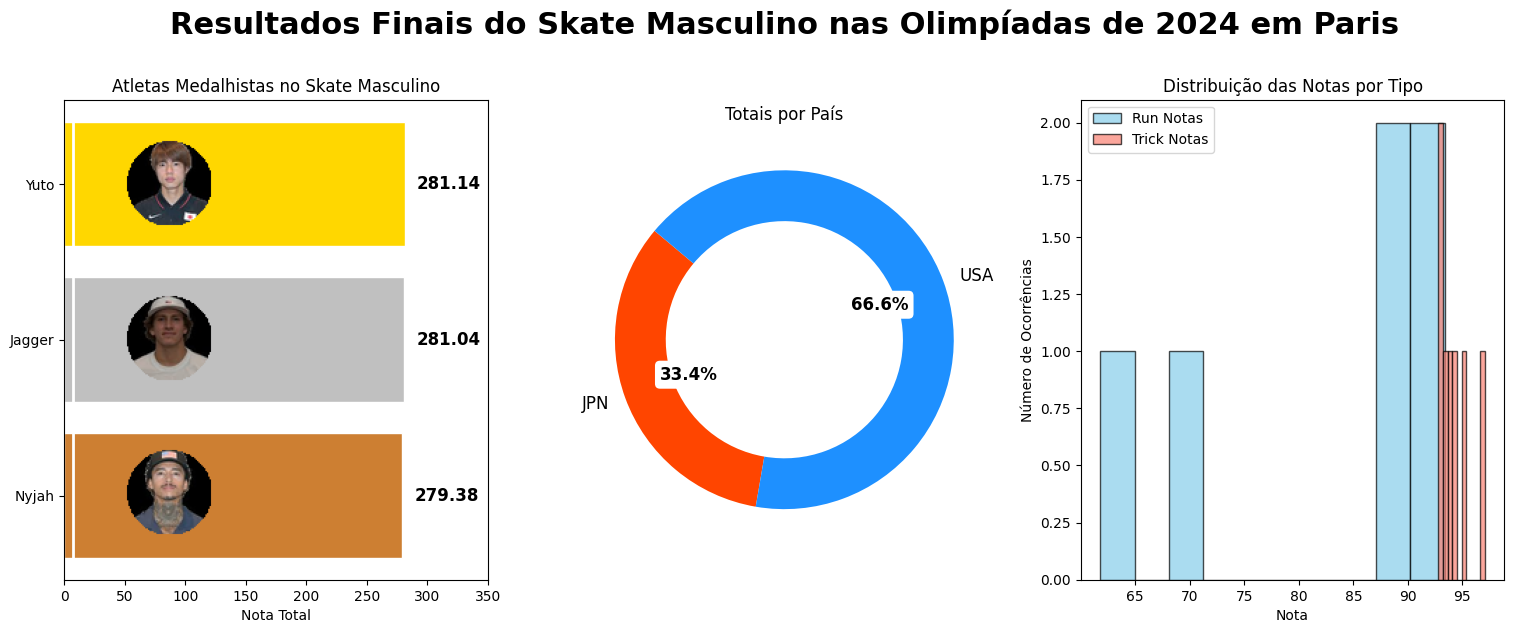

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import requests
from PIL import Image, ImageDraw
from io import BytesIO
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.patches import Rectangle
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf
from pyspark.sql.types import FloatType

# Configurações e Constantes
MEDAL_COLORS = {1: '#FFD700', 2: '#C0C0C0', 3: '#cd7f32'}
DEFAULT_COLOR = '#4C72B0'
COUNTRY_COLORS = {
    'JPN': '#FF4500',
    'USA': '#1E90FF',
    'BRA': '#3CB371',
    'CHN': '#FFD700'
}
IMAGE_URLS = {
    'Yuto': 'https://ssl.gstatic.com/onebox/media/sports/headshots/8u56w4ymL7sVelHI_108x108.jpg',
    'Jagger': 'https://ssl.gstatic.com/onebox/media/sports/headshots/sx8Y1VAZ7RKmSKN3_108x108.jpg',
    'Nyjah': 'https://ssl.gstatic.com/onebox/media/sports/headshots/9YTweAdUgcnIcEj8_108x108.jpg'
}

# Inicializa a SparkSession
spark = SparkSession.builder.appName("SkateOlimpico").getOrCreate()

# Função UDF para calcular a nota final
def calcular_nota_final(run1, run2, trick1, trick2, trick3, trick4, trick5):
    runs = [run1, run2]
    tricks = [trick1, trick2, trick3, trick4, trick5]
    
    # Nota da melhor run
    melhor_run = max(runs)
    
    # Duas maiores notas de tricks
    maiores_tricks = sorted(tricks, reverse=True)[:2]
    
    # Nota final
    nota_final = melhor_run + sum(maiores_tricks)
    
    return float(nota_final)

calcular_nota_final_udf = udf(calcular_nota_final, FloatType())

# Atualizando os nomes das colunas conforme o seu DataFrame
df_masculino = df_masculino.withColumn('Total', calcular_nota_final_udf(
    col('Run 1'), col('Run 2'), col('Trick 1'), col('Trick  2'), col('Trick  3'), col('Trick 4'), col('Trick 5')
)).withColumn('Medalha', col('Rank').cast('int'))

# Converter para Pandas e filtrar medalhistas
df_pandas = df_masculino.toPandas()
df_pandas = df_pandas[df_pandas['Medalha'].isin([1, 2, 3])]

# Função para carregar imagem
def load_image_from_url(url):
    try:
        response = requests.get(url)
        return Image.open(BytesIO(response.content)).convert("RGBA")
    except Exception as e:
        print(f"Erro ao carregar imagem: {e}")
        return None

# Função para criar uma imagem circular com borda
def make_circle_image(image, radius=30, border_color='#FFFFFF', border_width=5):
    image = image.resize((2 * radius, 2 * radius), Image.LANCZOS)
    mask = Image.new("L", (2 * radius, 2 * radius), 0)
    draw = ImageDraw.Draw(mask)
    draw.ellipse((0, 0, 2 * radius, 2 * radius), fill=255)
    circle_image = Image.new("RGBA", (2 * radius, 2 * radius))
    circle_image.paste(image, (0, 0), mask=mask)
    border = Image.new("RGBA", (2 * radius + 2 * border_width, 2 * radius + 2 * border_width), border_color)
    border.paste(circle_image, (border_width, border_width), mask=mask)
    return border

# Configurar a figura e os subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Gráfico 1: Medalhistas
top_atletas = df_pandas[['Nome', 'Total', 'Medalha']]
top_atletas = top_atletas.sort_values(by='Total', ascending=False)
bars = axs[0].barh(top_atletas['Nome'], top_atletas['Total'], color=[MEDAL_COLORS.get(medal, DEFAULT_COLOR) for medal in top_atletas['Medalha']], edgecolor='white')

# Adicionar uma borda externa branca ao redor do gráfico
axs[0].add_patch(Rectangle(
    (axs[0].get_position().x0 - 0.02, axs[0].get_position().y0 - 0.02),  # Posição do retângulo (margem extra)
    axs[0].get_position().width + 0.04,  # Largura do retângulo (largura do gráfico + margem extra)
    axs[0].get_position().height + 0.04,  # Altura do retângulo (altura do gráfico + margem extra)
    transform=fig.transFigure,  # Coordenadas relativas à figura
    color='white',  # Cor da borda
    fill=False,  # Não preencher o retângulo
    linewidth=2  # Largura da borda
))

# Adicionar imagens circulares sobre as barras
for i, nome in enumerate(top_atletas['Nome']):
    if nome in IMAGE_URLS:
        img = load_image_from_url(IMAGE_URLS[nome])
        if img:
            img_circular = make_circle_image(img, radius=30, border_color=MEDAL_COLORS.get(top_atletas.iloc[i]['Medalha'], DEFAULT_COLOR))
            bar_width = bars[i].get_width()
            img_width, img_height = img_circular.size
            x = bars[i].get_x() + 5
            y = bars[i].get_y() + (bars[i].get_height() - img_height) / 2
            imagebox = OffsetImage(img_circular, zoom=1.0, resample=True)
            ab = AnnotationBbox(imagebox, (x + img_width / 2, y + img_height / 2), frameon=False, pad=0, xycoords='data', boxcoords="offset points")
            axs[0].add_artist(ab)

# Adicionar o total ao lado das barras
for bar in bars:
    axs[0].text(
        bar.get_width() + 10,  # Posição horizontal do texto
        bar.get_y() + bar.get_height() / 2,  # Posição vertical do texto
        f'{bar.get_width():.2f}',  # Total
        ha='left', va='center', color='black', fontsize=12, fontweight='bold'
    )

# Ajustar o gráfico de medalhistas
axs[0].set_xlim(0, 350)
axs[0].set_title('Atletas Medalhistas no Skate Masculino')
axs[0].set_xlabel('Nota Total')
axs[0].invert_yaxis()

# Gráfico 2: Distribuição das Notas Totais por País
country_total = df_pandas.groupby('code')['Total'].sum()
colors_pie = [COUNTRY_COLORS.get(country, DEFAULT_COLOR) for country in country_total.index]
wedges, texts, autotexts = axs[1].pie(
    country_total,
    labels=country_total.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors_pie,
    wedgeprops=dict(width=0.3),
    textprops=dict(color='black', fontsize=12)
)
axs[1].set_title('Totais por País')

# Destacar os valores no gráfico de rosca
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(12)
    autotext.set_fontweight('bold')
    autotext.set_bbox(dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3'))

# Gráfico 3: Distribuição das Notas por Tipo (Run e Trick)
run_notas = df_pandas[['Run 1', 'Run 2']].values.flatten()
trick_notas = df_pandas[['Trick 1', 'Trick  2', 'Trick  3', 'Trick 4', 'Trick 5']].values.flatten()
run_notas = run_notas[run_notas > 0]
trick_notas = trick_notas[trick_notas > 0]

axs[2].hist(run_notas, bins=10, alpha=0.7, label='Run Notas', color='skyblue', edgecolor='black')
axs[2].hist(trick_notas, bins=10, alpha=0.7, label='Trick Notas', color='salmon', edgecolor='black')
axs[2].set_title('Distribuição das Notas por Tipo')
axs[2].set_xlabel('Nota')
axs[2].set_ylabel('Número de Ocorrências')
axs[2].legend()

# Ajuste para evitar o erro do tight_layout
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
plt.suptitle("Resultados Finais do Skate Masculino nas Olimpíadas de 2024 em Paris", fontsize=22, fontweight='bold', y=1.05)

# Mostrar o gráfico
plt.show()
